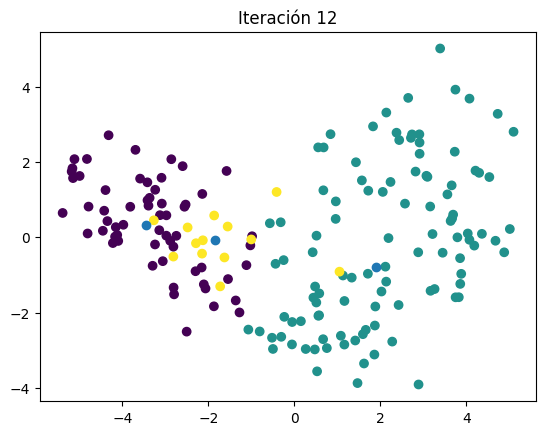

Objetos por cluster:
1    105
0     60
2     13
Name: count, dtype: int64
---
1206.6600514037448
---
Mejores varianzas:
     Nonflavanoid_phenols  0D280_0D315_of_diluted_wines   Proline
0                3.547170                      9.736264  6.052068
1                3.207547                      8.021978  5.955777
2                3.886792                      7.263736  6.822397
3                2.867925                      8.186813  8.716120
4                5.415094                      6.472527  3.933666
..                    ...                           ...       ...
173              7.622642                      2.549451  3.965763
174              6.094340                      1.956044  4.029957
175              6.094340                      1.956044  4.575606
176              7.792453                      2.153846  4.607703
177              8.301887                      2.087912  2.810271

[178 rows x 3 columns]


In [105]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
  
dataset = fetch_ucirepo(id=109) 
#dataset = fetch_ucirepo(id=292) 
  
'''
Escalamiento (normalización) de datos:
'''
atributos = dataset.data.features 
atributos_escalados = ((atributos - atributos.min()) / (atributos.max() - atributos.min())) * 9 + 1


'''
Aplicación de un límite de varianza.

"The Variance Threshold is a feature selector that removes low-variance features, which are typically of no significant use in modeling. 
It evaluates features independently and is suitable for unsupervised learning tasks."
https://medium.com/@nirmalsankalana/k-means-clustering-choosing-optimal-k-process-and-evaluation-methods-2c69377a7ee4
'''
limite_varianza = VarianceThreshold(threshold=4)  # Se eligió 4 arbitrariamente para obtener a los 3 atributos con mayor varianza.

limite_varianza.fit(atributos_escalados)

limite_varianza.get_support()

atributos_baja_varianza = [col for col in atributos_escalados.columns if col not in atributos_escalados.columns[limite_varianza.get_support()]]

atributos_alta_varianza = atributos_escalados.drop(atributos_baja_varianza, axis=1)

datos = atributos_alta_varianza.copy()


def get_centroides_aleatorios(datos, k: int = 5):
  '''
  Genera K centroides aleatorios.
  '''
  centroides = []
  for _ in range(k):
    '''
    Por cada atributo (columnas del dataframe), selecciona un valor al azar,
    y convierte en float.  El resultado es centroide, que es un panda series
    con todos sus atributos y valores aleatorios correspondientes.

    repite k-veces.
    '''
    centroide = datos.apply(lambda atributo: float(atributo.sample()))
    centroides.append(centroide)

  '''
  combina todos los centroides, que son panda series individuales, en un sólo panda dataframe.
  '''
  return pd.concat(centroides, axis=1)


def get_cluster_labels(datos, centroides):
  '''
  Genera un Dataframe con los labels del cluster al que cada dato pertenece.
  '''

  '''
  - Calcula la distancia euclidiana de todos los objetos y todos los centroides
    - centroides.apply(): Por cada centroide (cada columna en el dataframe centroides): 
    - (datos - centroide): A cada valor de cada fila de datos, restar el valor correspondiente del centroide.
    - ((datos - centroide) ** 2 ): elevar ^2 todos los valores del dataframe
    - .sum(axis=1): sumar las FILAS del dataframe
    - .sqrt(): Sacar raiz del dataframe resultante
    - El resultado es un dataframe de una columna, con las distancias euclidianas entre todos los datos y 
      el centroide de esta iteración
    - repetir con el siguiente centroide

  - El resultado es distancias, un dataframe donde cada fila es un dato del dataset, y cada columna es la distancia entre 
  el dato y un centroide.

              0         1         2
  0    1.521521  1.709799  0.769451
  1    1.957002  2.064981  0.610309
  2    2.347268  1.525178  2.436947

  '''
  distancias = centroides.apply(lambda centroide: np.sqrt( ((datos - centroide) ** 2).sum(axis=1) )) 
  '''
  - De las distancias, se consiguen las menores
    - idxmin(axis=1) consigue un dataframe de una columna, donde cada fila contiene el índice de la distancia más corta 
    en cada fila de distancias. Cada índice representa un cluster distinto.

  0   2
  1   2
  2   1
  '''
  return distancias.idxmin(axis=1)


def get_centroides_nuevos(datos, clusters): 
  '''
  Calcula centroides usando el promedio geométrico de cada cluster.
  '''

  '''
  - datos.groupby(clusters): Agrupar datos por cluster.
  - .apply():   Por cada cluster, calcular el promedio geométrico de sus atributos.
    - np.log(): Obtener log de todos los datos del cluster.
    - .mean():  Obtener promedio de esos logs
    - .exp():   Promedio está en log; convertir a base 10.
  '''
  
  return datos.groupby(clusters).apply(lambda datos_del_cluster: np.exp(np.log(datos_del_cluster).mean())).T

def graficar_clusters(datos, clusters, centroides, iteracion):
  pca = PCA(n_components= 2)
  datos_2d = pca.fit_transform(datos)
  centroides_2d = pca.transform(centroides.T)
  clear_output(wait=True)
  plt.title(f'Iteración {iteracion}')
  plt.scatter(x=datos_2d[:,0], y=datos_2d[:,1], c=clusters)
  plt.scatter(x=centroides_2d[:,0], y=centroides_2d[:,1])
  plt.show()

def get_distancias(datos, centroides):
  '''
  Genera un Dataframe con los labels del cluster al que cada dato pertenece.
  '''

  distancias = centroides.apply(lambda centroide: np.sqrt( ((datos - centroide) ** 2).sum(axis=1) )) 
  return distancias.min(axis=1)

MAX_ITERACIONES = 100
K = 3

centroides = get_centroides_aleatorios(datos=datos, k=K)
centroides_anteriores = pd.DataFrame()
iteracion = 1

while iteracion < MAX_ITERACIONES and not centroides.equals(centroides_anteriores):
  centroides_anteriores = centroides
  cluster_labels = get_cluster_labels(datos=datos, centroides=centroides)
  centroides = get_centroides_nuevos(datos=datos, clusters=cluster_labels)
  graficar_clusters(datos=datos, clusters=cluster_labels, centroides=centroides, iteracion=iteracion)
  iteracion += 1

cluster_labels = get_cluster_labels(datos=datos, centroides=centroides)
distancias = get_distancias(datos=datos, centroides=centroides)


print("Objetos por cluster:")
print(cluster_labels.value_counts())
print("---")
print((distancias**2).sum(axis=0))
print("---")

print("Mejores varianzas:")
print(datos)